In [1]:
import sys

In [2]:
sys.path.append("/scratch/mz2476/DL/project/fastai")
sys.path.append("/scratch/mz2476/DL/project/")

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
from data_loaders import plot_utils

from data_loaders import data_helper
reload(data_helper)

from fastai import *
from fastai.vision import *

from ssl_project import constants
from glob import glob

import imageio

from ssl_project.constants import *

import torchvision


from ssl_project.vehicle_layout_prediction.bb_utils import ProcessSegmentationMaps
from ssl_project.utils import compute_ats_bounding_boxes_NEW
from tqdm import tqdm_notebook as tqdm

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
# OUR_FNAMES = np.concatenate([
#     glob(f"data/scene_{scene_idx}/*/*.jpeg") 
#     for scene_idx in constants.LABELED_SCENE_INDEX
# ])

# OUR_FNAMES = np.unique([f"{path.rsplit('/', 1)[0]}/WARPED_3WW_top_down_segm.png" for path in OUR_FNAMES])


# np.savetxt("labeled_images.csv", ["kek"] + list(OUR_FNAMES), fmt='%s', delimiter=",")

## this one is needed to run only once

In [5]:
OUR_FNAMES = np.loadtxt("labeled_images.csv", skiprows=1, dtype='str')

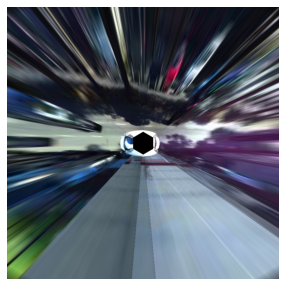

In [6]:
img_f = OUR_FNAMES[0]
img = open_image(img_f)
img.show(figsize=(5, 5))

In [7]:
def get_y_fn_png(path):
    return f"{path.rsplit('/', 1)[0]}/CARS_top_down_segm.png"

In [8]:
NUM_VAL_SCENES = 3
NUM_TRAIN_SCENES = len(LABELED_SCENE_INDEX) - NUM_VAL_SCENES
TRAIN_IDCES = range(NUM_TRAIN_SCENES * NUM_SAMPLE_PER_SCENE)
VAL_IDCES   = range(NUM_TRAIN_SCENES * NUM_SAMPLE_PER_SCENE, 
                    len(LABELED_SCENE_INDEX) * NUM_SAMPLE_PER_SCENE)


In [9]:
classes = ["Nothing", "cars"] # Load data codes
size = 200 # instead of 800
bs = 32

src = (
    SegmentationItemList.from_csv("", "labeled_images.csv")
    .split_by_idxs(TRAIN_IDCES, VAL_IDCES)
    .label_from_func(get_y_fn_png, classes=classes)
)

In [10]:
[x_trans, y_trans] = get_transforms()
data = (src.transform([x_trans[-1], y_trans], size=size, tfm_y=True).databunch(bs=bs).normalize(imagenet_stats))

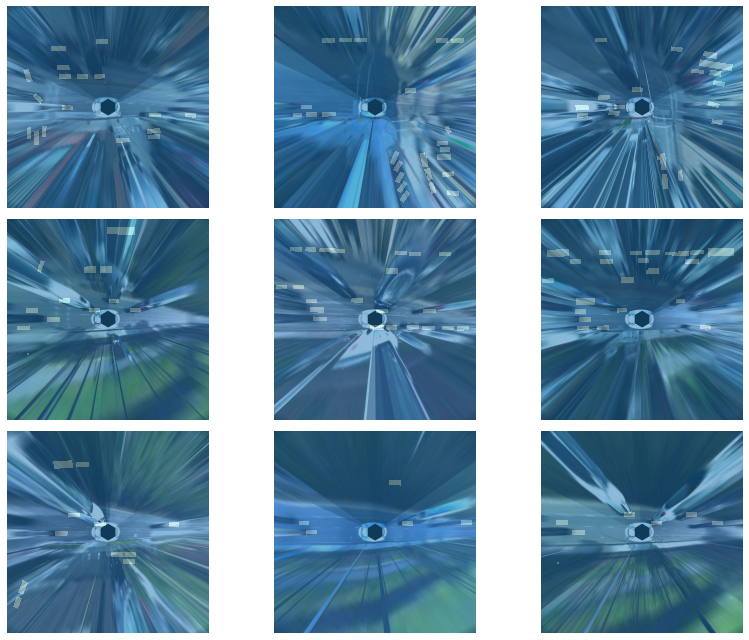

In [13]:
data.show_batch(rows=3, figsize=(12, 9))

In [14]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [15]:
learn = unet_learner(data, models.resnet34, wd=1e-2, pretrained=False)


In [16]:
# learn.loss_func = FocalLoss(logits=True)

In [17]:
import fastai.vision

In [19]:
learn.lr_find() # find learning rate

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


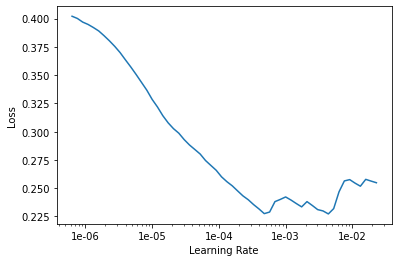

In [20]:
learn.recorder.plot()

In [21]:
# learn.fit_one_cycle??

In [23]:
lr = 3e-4 # pick a lr
learn.fit(5, slice(lr),wd=1e-2, use_swa=True) # train model

TypeError: fit() got an unexpected keyword argument 'use_swa'

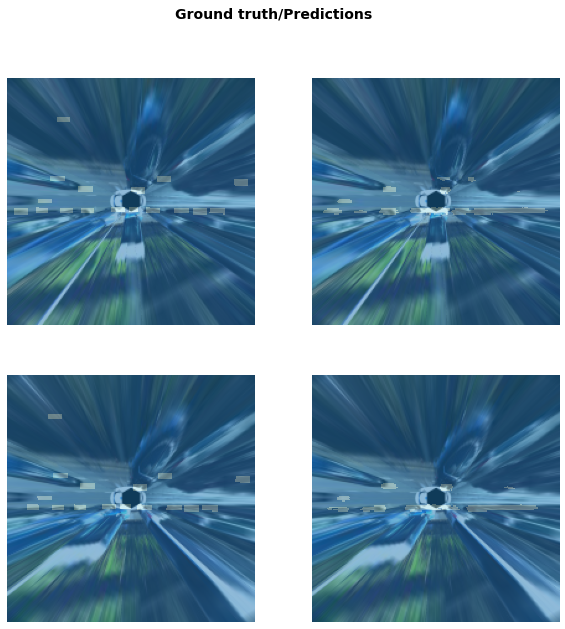

In [33]:
learn.show_results(rows=2, figsize=(10, 10)) # show results

# Val ts score

In [34]:
process_segm = ProcessSegmentationMaps()
up = nn.Upsample(size=(800, 800))

def batch_maps_to_bbs(fcast_WW, threshold=0.5):
    bbs_k24 = process_segm.transform(fcast_WW, threshold=threshold)
    if len(bbs_k24) > 0:
        bbs_k24 = process_segm.convert_to_bb_space(bbs_k24, axis=-2)
    else:
        bbs_k24 = torch.zeros((1,2,4))
    return bbs_k24

In [36]:



def get_scores_n(thr_n):
    scores_n = []

    for thr in thr_n:
        total = 0
        total_ats_bounding_boxes = 0
        for i, (_x_b3ww, _y_b1ww) in enumerate(tqdm(data.valid_dl)):
            for x_3ww, y_1ww in zip(_x_b3ww, _y_b1ww):
                total += 1
                fcast_2WW = up(learn.model(x_3ww[None]))[0]
                y_WW = up(y_1ww[None].float())[0, 0]
                fcast_WW = F.softmax(fcast_2WW, dim=-3)[1, :, :]
                pred_bbs = batch_maps_to_bbs(fcast_WW, thr)
                targ_bbs = batch_maps_to_bbs(y_WW)
                ats_bounding_boxes = compute_ats_bounding_boxes_NEW(pred_bbs, targ_bbs)

                total_ats_bounding_boxes += ats_bounding_boxes

        scores_n.append(total_ats_bounding_boxes / total)

    return np.array(scores_n)    
    
#     print(f'{thr}: {total_ats_bounding_boxes / total:.4}')

In [37]:
thr_n    = np.array([0.2, 0.3, 0.4, 0.5, 0.6])
scores_n = get_scores_n(thr_n)

<ipython-input-36-081f8aa04d0b>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, (_x_b3ww, _y_b1ww) in enumerate(tqdm(data.valid_dl)):


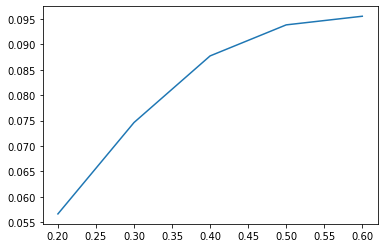

In [38]:
plt.plot(thr_n, scores_n)

In [39]:
thr_n    = np.array([0.6, 0.65, 0.7])
scores_n = get_scores_n(thr_n)

<ipython-input-36-081f8aa04d0b>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, (_x_b3ww, _y_b1ww) in enumerate(tqdm(data.valid_dl)):


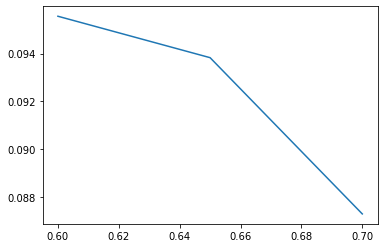

In [40]:
plt.plot(thr_n, scores_n)

In [42]:
# torch.save({"model" : learn.model, "num_epochs" : 8, "bs" : 32, "lr" : 3e-3}, 
#              "pretrained_models/cars_unet_final_v2222.pth")